<a href="https://colab.research.google.com/github/pvdklei/modelsmakemodels/blob/master/pepijn/autoenc_repr_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import train
import utils

In [2]:
traintransform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testtransform = traintransform

batch_size = 32
num_workers = 2

trainset = datasets.CIFAR10("/data/cifar10/train", train=True, transform=traintransform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = datasets.CIFAR10("/data/cifar10/test", train=False, transform=testtransform, download=True)
testloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Extracting /data/cifar10/train/cifar-10-python.tar.gz to /data/cifar10/train


Extracting /data/cifar10/test/cifar-10-python.tar.gz to /data/cifar10/test


In [3]:
imiter = iter(trainloader)
images, _ = next(imiter)
image = images[0]
images.shape

torch.Size([32, 3, 32, 32])

In [28]:
class Encoder(nn.Module):
    def __init__(self, im_size, repr_size):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.2)

        conv_out_channels = 16
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, conv_out_channels, kernel_size=3)

        lin_input_size = utils.conv_out_shape(im_size, 3) # conv1
        lin_input_size = utils.conv_out_shape(lin_input_size, 2, stride=2) # pool1
        lin_input_size = utils.conv_out_shape(lin_input_size, 3) # conv2
        lin_input_size = utils.conv_out_shape(lin_input_size, 2, stride=2) # pool2
        lin_input_size = lin_input_size[0] * lin_input_size[1] * conv_out_channels # reshape

        self.fc1 = nn.Linear(lin_input_size, repr_size)

    def forward(self, x):
        # print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(x.shape[0], -1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # print(x.shape)
        return x
        
enc = Encoder(32, 10)
enc(images).shape

torch.Size([32, 10])

In [30]:
class Decoder(nn.Module):
    def __init__(self, repr_size, im_size):
        super().__init__()
        self.drop = nn.Dropout(0.2)

        self.conv_input_chans = 16

        # calc conv input shapes needed for 32x32 output
        size = utils.convt_out_shape(im_size, 3)
        size = utils.conv_out_shape(size, 3)
        self.conv_input_size = utils.conv_out_shape(size, 3)
        lin_output_size = utils.flatten_size(self.conv_input_size, self.conv_input_chans)


        self.fc1 = nn.Linear(repr_size, lin_output_size)

        self.conv1 = nn.ConvTranspose2d(self.conv_input_chans, 32, kernel_size=3)
        self.conv2 = nn.ConvTranspose2d(32, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 3, kernel_size=3)
    
    def forward(self, x):
        x = self.drop(F.relu(self.fc1(x)))
        x = x.view(x.shape[0], self.conv_input_chans, *self.conv_input_size)
        x = self.drop(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

decoder = Decoder(10, 32)
decoder(enc(images)).shape

torch.Size([32, 3, 32, 32])

In [31]:
class AutoEncoder(nn.Module):
    def __init__(self, input, repr):
        super().__init__()
        self.encoder = Encoder(input, repr)
        self.decoder = Decoder(repr, input)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoenc = AutoEncoder(32, 10)
autoenc(images).shape

torch.Size([32, 3, 32, 32])

In [41]:
class Classifier(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.drop = nn.Dropout(0.4)
        self.fc1 = nn.Linear(input_size, 
                             utils.intlerp(0.33, input_size, output_size))
        self.fc2 = nn.Linear(utils.intlerp(0.33, input_size, output_size), 
                          utils.intlerp(0.66, input_size, output_size))
        self.fc3 = nn.Linear(utils.intlerp(0.66, input_size, output_size), 
                          output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

mod = Classifier(10, 5)
mod(enc(images)).shape

torch.Size([32, 5])

In [19]:
mix = nn.Sequential(Encoder(32, 10),
                    Classifier(10, 10))
mix(images).shape

torch.Size([32, 10])

In [32]:
model = AutoEncoder(32, 1000)
model

AutoEncoder(
  (encoder): Encoder(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout(p=0.2, inplace=False)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (fc1): Linear(in_features=576, out_features=1000, bias=True)
  )
  (decoder): Decoder(
    (drop): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=1000, out_features=14400, bias=True)
    (conv1): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1))
  )
)

In [33]:
train.autotrain(model,
                optim.Adam(params=model.parameters(), lr=0.001),
                trainloader, testloader,
                nn.MSELoss(),
                epochs=5)

cuda
Epoch 0, Training loss: 401.77690602838993
Epoch 0, Validation loss: 400.1049499511719
Epoch 1, Training loss: 400.1006436944008
Epoch 1, Validation loss: 400.10150146484375
Epoch 2, Training loss: 400.091588512063


KeyboardInterrupt: ignored

torch.Size([32, 3, 32, 32])


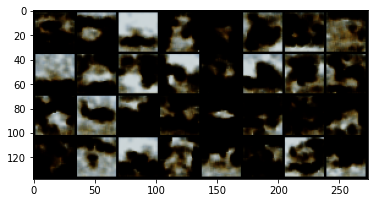

In [22]:

def showimage(image):
    image = image.detach().numpy()
    image = image.transpose((1, 2, 0))
    plt.imshow(image)
cpumodel = model.cpu()
out = cpumodel(images)
print(out.shape)
showimage(torchvision.utils.make_grid(out))
# showimage(torchvision.utils.make_grid(images))

In [29]:

import importlib
utils = importlib.reload(utils)
train = importlib.reload(train)